In [14]:
import pandas as pd

df = pd.read_csv("../../datasets/pima_indian_diabetes_dataset/cleaned_dataset.csv")
df.head()

,Pregnancies,Glucose,Blood Pressure,Skin Thickness,Insulin,BMI,Diabetes Pedigree Function,Age,Outcome
0,2,108,62,32,56,25.2,0.128,21,0
1,0,137,68,14,148,24.8,0.143,21,0
2,1,89,66,23,94,28.1,0.167,21,0
3,0,139,62,17,210,22.1,0.207,21,0
4,4,99,76,15,51,23.2,0.223,21,0


In [15]:
stats_by_class = df.groupby('Outcome').agg(['mean', 'std'])
display(stats_by_class)


Pregnancies               Glucose            Blood Pressure  \
               mean       std        mean        std           mean   
Outcome                                                               
0          2.721374  2.617844  111.431298  24.642133      68.969466   
1          4.469231  3.916153  145.192308  29.839388      74.076923   

                   Skin Thickness                Insulin              \
               std           mean        std        mean         std   
Outcome                                                                
0        11.892841      27.251908  10.434135  130.854962  102.626177   
1        13.021518      32.961538   9.642770  206.846154  132.699898   

               BMI           Diabetes Pedigree Function                 Age  \
              mean       std                       mean      std       mean   
Outcome                                                                       
0        31.750763  6.794971                   0.472168  0.29924  28.347328   
1        35.777692  6.734687                   0.625585  0.40591  35.938462   

                    
               std  
Outcome             
0         8.989008  
1        10.634705

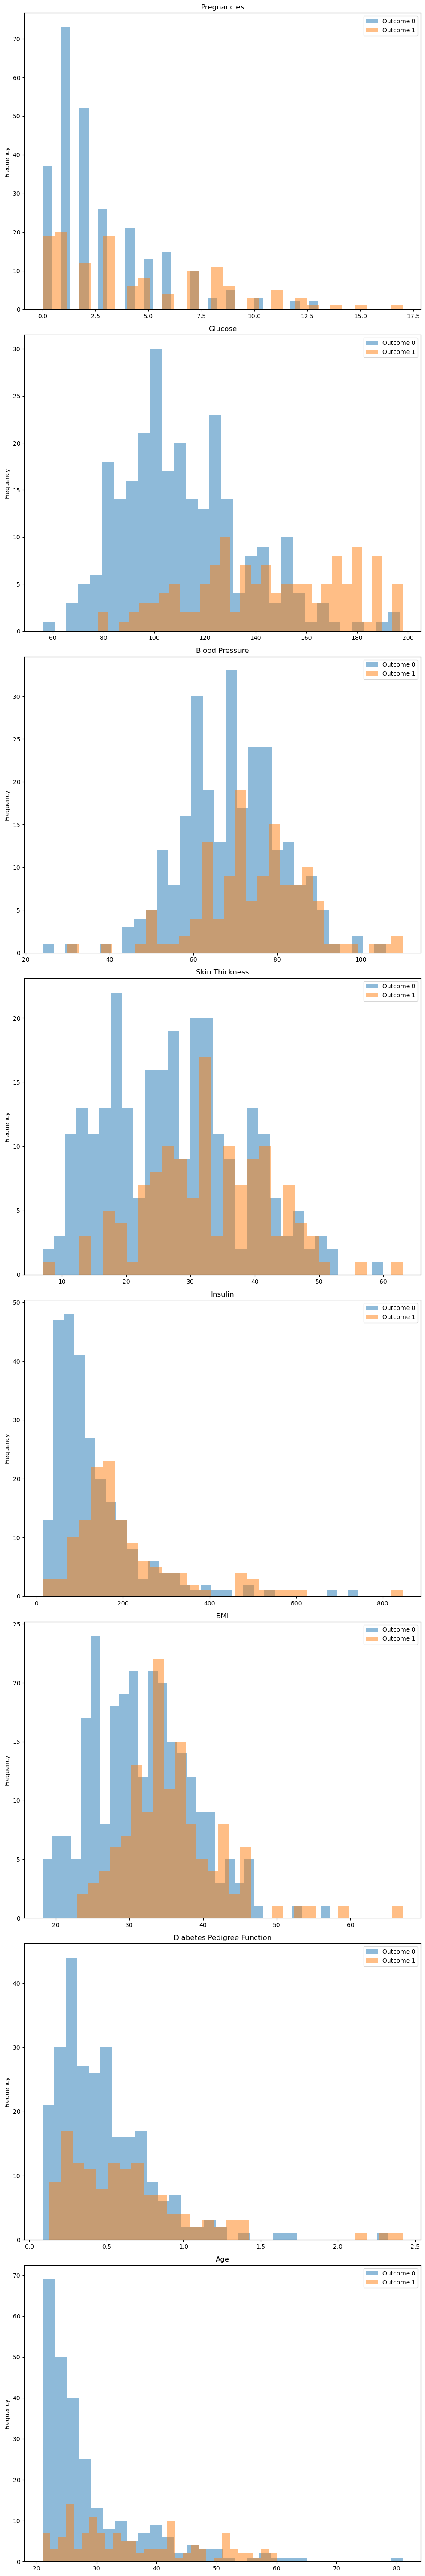

In [16]:
import matplotlib.pyplot as plt

features = df.columns.drop('Outcome')
outcomes = df['Outcome'].unique()

fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(10, 60))
axes = axes.flatten()

for idx, feature in enumerate(features):
    for outcome in outcomes:
        df[df['Outcome'] == outcome][feature].plot(
            kind='hist', 
            bins=30, 
            alpha=0.5, 
            ax=axes[idx], 
            label=f'Outcome {outcome}'
        )
    axes[idx].set_title(feature)
    axes[idx].legend()

plt.tight_layout()
plt.show()

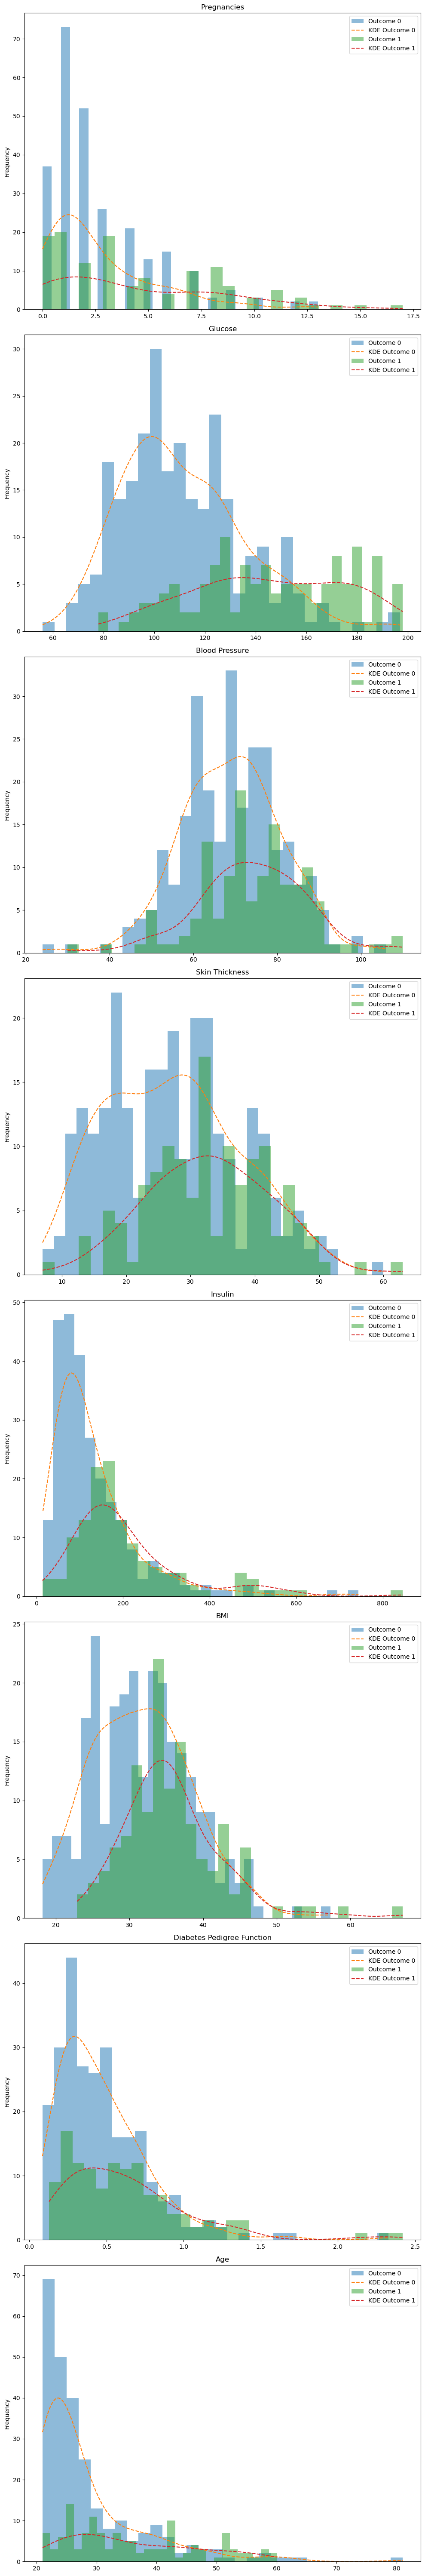

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

features = df.columns.drop('Outcome')
outcomes = df['Outcome'].unique()

fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(10, 60))
axes = axes.flatten()

for idx, feature in enumerate(features):
    for outcome in outcomes:
        data = df[df['Outcome'] == outcome][feature]
        data.plot(
            kind='hist', 
            bins=30, 
            alpha=0.5, 
            ax=axes[idx], 
            label=f'Outcome {outcome}'
        )
        # Add KDE
        if len(data) > 1 and data.std() > 0:
            kde = gaussian_kde(data)
            x_vals = np.linspace(data.min(), data.max(), 200)
            axes[idx].plot(x_vals, kde(x_vals) * len(data) * (data.max() - data.min()) / 30, 
                           label=f'KDE Outcome {outcome}', linestyle='--')
    axes[idx].set_title(feature)
    axes[idx].legend()

plt.tight_layout()
plt.show()

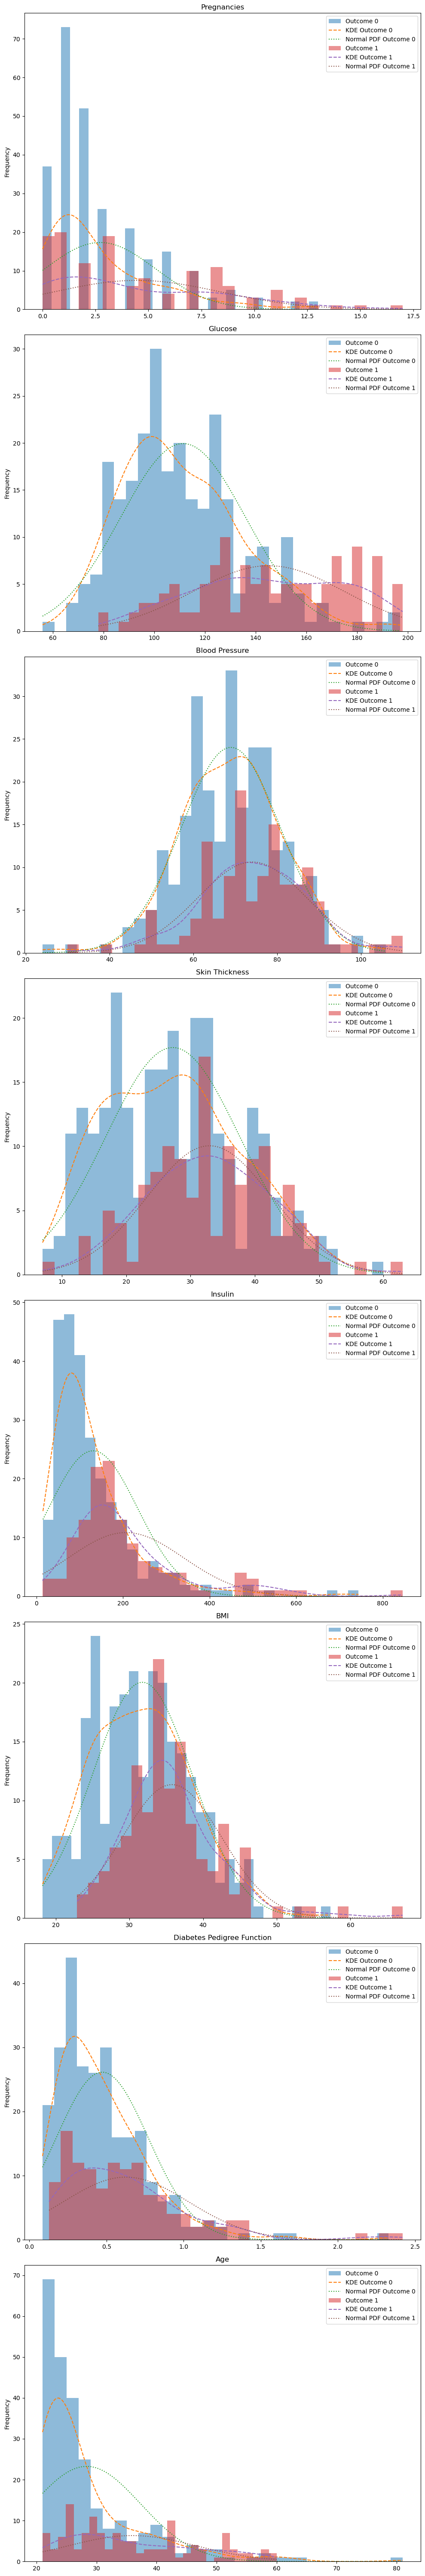

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde, norm

features = df.columns.drop('Outcome')
outcomes = df['Outcome'].unique()

fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(10, 60))
axes = axes.flatten()

for idx, feature in enumerate(features):
    for outcome in outcomes:
        data = df[df['Outcome'] == outcome][feature]
        data.plot(
            kind='hist', 
            bins=30, 
            alpha=0.5, 
            ax=axes[idx], 
            label=f'Outcome {outcome}'
        )
        # Add KDE
        if len(data) > 1 and data.std() > 0:
            kde = gaussian_kde(data)
            x_vals = np.linspace(data.min(), data.max(), 200)
            axes[idx].plot(
                x_vals, 
                kde(x_vals) * len(data) * (data.max() - data.min()) / 30, 
                label=f'KDE Outcome {outcome}', linestyle='--'
            )
        # Add Normal PDF using class mean and std
        mean = stats_by_class.loc[outcome, (feature, 'mean')]
        std = stats_by_class.loc[outcome, (feature, 'std')]
        if std > 0:
            pdf_x = np.linspace(data.min(), data.max(), 200)
            pdf_y = norm.pdf(pdf_x, mean, std)
            scale = len(data) * (data.max() - data.min()) / 30
            axes[idx].plot(
                pdf_x, 
                pdf_y * scale, 
                label=f'Normal PDF Outcome {outcome}', linestyle=':'
            )
    axes[idx].set_title(feature)
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [25]:
import pandas as pd
from scipy.stats import normaltest, shapiro, anderson

# Create a MultiIndex DataFrame to store results
index = pd.MultiIndex.from_product([outcomes, features], names=["Outcome", "Feature"])

# Use clear column names
columns = [
    "Shapiro-Wilk p-value",
    "D’Agostino-Pearson p-value",
    "Anderson-Darling statistic",
    "Anderson-Darling critical (5%)",
    "Majority voting"
]

normality_results = pd.DataFrame(index=index, columns=columns)

for outcome in outcomes:
    for feature in features:
        data = df[df['Outcome'] == outcome][feature]
        data = data.dropna()  # In case there are NaNs
        
        # D’Agostino-Pearson normality test
        stat1, p1 = normaltest(data)
        
        # Shapiro-Wilk test
        stat2, p2 = shapiro(data)
        
        # Anderson-Darling test
        result3 = anderson(data)
        stat3 = result3.statistic
        crit_5 = result3.critical_values[2]  # 5% level
        
        # Each test votes True if p > 0.05 (normal), or Anderson stat < critical value
        votes = [
            p2 > 0.05,
            p1 > 0.05,
            stat3 < crit_5
        ]
        
        # Majority voting
        is_normal = sum(votes) >= 2
        
        # Store results
        normality_results.loc[(outcome, feature), :] = [
            p2,
            p1,
            stat3,
            crit_5,
            is_normal
        ]

# Display the full table
display(normality_results)


Shapiro-Wilk p-value  \
Outcome Feature                                           
0       Pregnancies                                 0.0   
        Glucose                                0.000006   
        Blood Pressure                         0.072938   
        Skin Thickness                         0.000491   
        Insulin                                     0.0   
        BMI                                    0.004445   
        Diabetes Pedigree Function                  0.0   
        Age                                         0.0   
1       Pregnancies                                 0.0   
        Glucose                                0.011749   
        Blood Pressure                         0.087892   
        Skin Thickness                         0.957094   
        Insulin                                     0.0   
        BMI                                    0.000001   
        Diabetes Pedigree Function                  0.0   
        Age                                    0.000004   

                                   D’Agostino-Pearson p-value  \
Outcome Feature                                                 
0       Pregnancies                                       0.0   
        Glucose                                      0.000014   
        Blood Pressure                                0.07551   
        Skin Thickness                               0.007786   
        Insulin                                           0.0   
        BMI                                          0.015638   
        Diabetes Pedigree Function                        0.0   
        Age                                               0.0   
1       Pregnancies                                  0.001819   
        Glucose                                      0.000865   
        Blood Pressure                               0.110088   
        Skin Thickness                               0.850555   
        Insulin                                           0.0   
        BMI                                               0.0   
        Diabetes Pedigree Function                        0.0   
        Age                                          0.000505   

                                   Anderson-Darling statistic  \
Outcome Feature                                                 
0       Pregnancies                                   13.3428   
        Glucose                                      2.341509   
        Blood Pressure                               0.567865   
        Skin Thickness                               1.402511   
        Insulin                                     14.703534   
        BMI                                          0.708577   
        Diabetes Pedigree Function                   6.560965   
        Age                                         19.928407   
1       Pregnancies                                  3.835523   
        Glucose                                      0.876803   
        Blood Pressure                               0.618973   
        Skin Thickness                               0.182129   
        Insulin                                      6.993505   
        BMI                                          2.029397   
        Diabetes Pedigree Function                     3.5909   
        Age                                          2.904613   

                                   Anderson-Darling critical (5%)  \
Outcome Feature                                                     
0       Pregnancies                                         0.775   
        Glucose                                             0.775   
        Blood Pressure                                      0.775   
        Skin Thickness                                      0.775   
        Insulin                                             0.775   
        BMI                                                 0.775   
        Diabetes Pedigree Function                          0.775   
        A

In [26]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Outcome'])
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

Train shape: (313, 9), Test shape: (79, 9)


In [27]:
stats_by_class_train = train_df.groupby('Outcome').agg(['mean', 'std'])
display(stats_by_class_train)

Pregnancies               Glucose            Blood Pressure  \
               mean       std        mean        std           mean   
Outcome                                                               
0          2.722488  2.649296  111.191388  24.420037      68.956938   
1          4.403846  3.870524  146.471154  29.043642      73.298077   

                   Skin Thickness                Insulin              \
               std           mean        std        mean         std   
Outcome                                                                
0        12.365937      27.311005  10.421590  131.693780  103.163248   
1        13.300763      33.211538   9.902116  204.153846  125.091483   

               BMI           Diabetes Pedigree Function                  Age  \
              mean       std                       mean       std       mean   
Outcome                                                                        
0        31.922967  6.900282                   0.471273  0.310617  28.009569   
1        35.794231  7.009159                   0.611587  0.408377  36.192308   

                    
               std  
Outcome             
0         8.501691  
1        10.455710

In [28]:
priors = train_df['Outcome'].value_counts(normalize=True).sort_index()
print(priors)

Outcome
0    0.667732
1    0.332268
Name: proportion, dtype: float64


In [29]:
sample = test_df.sample(n=1, random_state=0)
display(sample)

,Pregnancies,Glucose,Blood Pressure,Skin Thickness,Insulin,BMI,Diabetes Pedigree Function,Age,Outcome
351,14,100,78,25,184,36.6,0.412,46,1


In [33]:
import numpy as np

def calculate_likelihood(x, mean, stdev):
    """Calculate the likelihood of x for a normal distribution with given mean and stdev."""
    exponent = np.exp(-((x - mean) ** 2) / (2 * stdev ** 2))
    return (1 / (np.sqrt(2 * np.pi) * stdev)) * exponent

In [34]:
# Calculate likelihoods for each feature in the test sample for each class
likelihoods = {}

for outcome in outcomes:
    likelihoods[outcome] = {}
    for feature in features:
        x = sample.iloc[0][feature]
        mean = stats_by_class_train.loc[outcome, (feature, 'mean')]
        std = stats_by_class_train.loc[outcome, (feature, 'std')]
        # Avoid division by zero
        if std > 0:
            likelihood = calculate_likelihood(x, mean, std)
        else:
            likelihood = 0.0
        likelihoods[outcome][feature] = likelihood

# Convert to DataFrame for better display
likelihoods_df = pd.DataFrame(likelihoods).T
display(likelihoods_df)

,Pregnancies,Glucose,Blood Pressure,Skin Thickness,Insulin,BMI,Diabetes Pedigree Function,Age
0,0.000017,0.014708,0.024692,0.037351,0.003401,0.045950,1.261183,0.005001
1,0.004768,0.003819,0.028177,0.028566,0.003148,0.056542,0.866924,0.024575


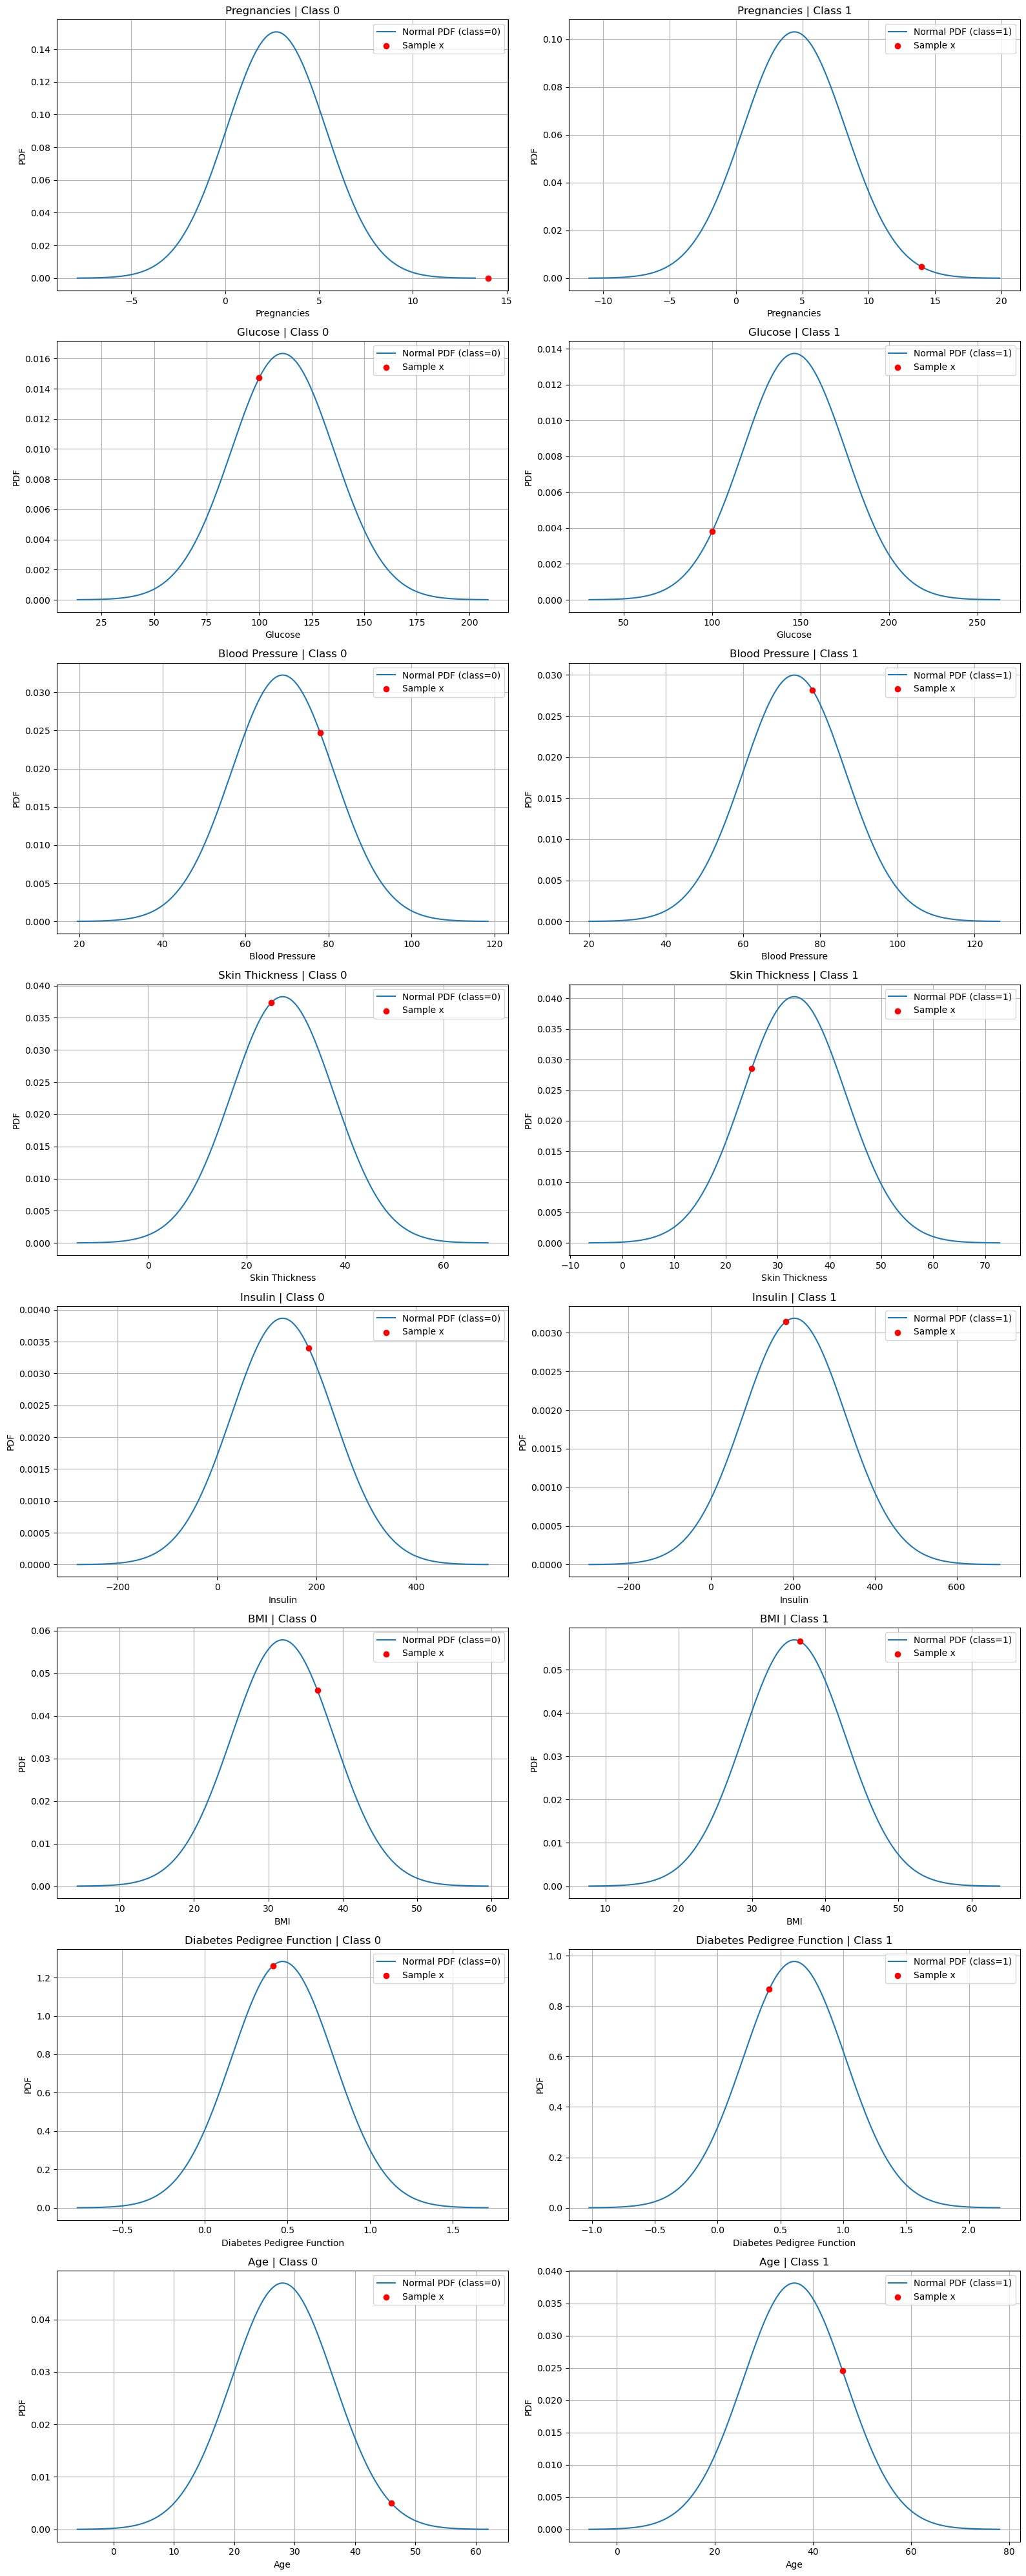

In [43]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt

# Plot for each feature and each class
fig, axes = plt.subplots(nrows=len(features), ncols=len(outcomes), figsize=(16, 40))
if len(features) == 1 or len(outcomes) == 1:
    axes = np.atleast_2d(axes)

for i, feature in enumerate(features):
    for j, outcome in enumerate(outcomes):
        ax = axes[i, j]
        # Get mean and std for this class/feature
        mean = stats_by_class_train.loc[outcome, (feature, 'mean')]
        std = stats_by_class_train.loc[outcome, (feature, 'std')]
        # Range for x axis
        x_min = mean - 4 * std
        x_max = mean + 4 * std
        x_vals = np.linspace(x_min, x_max, 200)
        # Normal PDF
        pdf = norm.pdf(x_vals, mean, std)
        ax.plot(x_vals, pdf, label=f'Normal PDF (class={outcome})')
        # Mark the sample value
        x_point = sample.iloc[0][feature]
        y_point = norm.pdf(x_point, mean, std)
        ax.scatter([x_point], [y_point], color='red', zorder=5, label='Sample x')
        ax.set_title(f"{feature} | Class {outcome}")
        ax.set_xlabel(feature)
        ax.set_ylabel("PDF")
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()

In [44]:
# Calculate posterior probabilities for each feature and each class
feature_posteriors = pd.DataFrame(index=outcomes, columns=features)

for feature in features:
    # Compute likelihoods for this feature for all classes
    likelihoods_feature = likelihoods_df[feature]
    # Compute unnormalized posteriors for each class
    posteriors_feature = {}
    for outcome in outcomes:
        posteriors_feature[outcome] = priors[outcome] * likelihoods_feature.loc[outcome]
    # Normalize
    total = sum(posteriors_feature.values())
    for outcome in outcomes:
        feature_posteriors.loc[outcome, feature] = posteriors_feature[outcome] / total if total > 0 else 0

display(feature_posteriors)


,Pregnancies,Glucose,Blood Pressure,Skin Thickness,Insulin,BMI,Diabetes Pedigree Function,Age
0,0.007321,0.885583,0.637819,0.724336,0.684627,0.620224,0.745128,0.29025
1,0.992679,0.114417,0.362181,0.275664,0.315373,0.379776,0.254872,0.70975


In [45]:
# Calculate log-likelihoods and posterior probabilities for each class
log_likelihoods = {}
for outcome in outcomes:
    log_likelihood = 0.0
    for feature in features:
        likelihood = likelihoods[outcome][feature]
        # Avoid log(0) by using a small value
        log_likelihood += np.log(likelihood + 1e-12)
    log_likelihoods[outcome] = log_likelihood + np.log(priors[outcome])

# Convert log-likelihoods to probabilities (softmax for numerical stability)
log_likelihoods_arr = np.array(list(log_likelihoods.values()))
max_log = np.max(log_likelihoods_arr)
exp_logs = np.exp(log_likelihoods_arr - max_log)
probs = exp_logs / exp_logs.sum()

# Map to class labels
log_probabilities = dict(zip(outcomes, probs))
print("Class probabilities (using log-likelihood):", log_probabilities)

Class probabilities (using log-likelihood): {0: 0.008386977509619845, 1: 0.9916130224903803}


In [46]:
# Predict the class for the test sample using the computed log probabilities
predicted_outcome = max(log_probabilities, key=log_probabilities.get)
print(f"Predicted Outcome: {predicted_outcome}")
print(f"Class probabilities: {log_probabilities}")

Predicted Outcome: 1
Class probabilities: {0: 0.008386977509619845, 1: 0.9916130224903803}


In [47]:
from sklearn.naive_bayes import GaussianNB

# Prepare data
X_test = test_df[features]
y_test = test_df['Outcome']
X_train = train_df[features]
y_train = train_df['Outcome']

# Fit GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predict probabilities for the same test sample
sklearn_probs = gnb.predict_proba(sample[features])[0]
sklearn_pred = gnb.predict(sample[features])[0]

print("Scikit-learn GaussianNB probabilities:", dict(zip(gnb.classes_, sklearn_probs)))
print("Scikit-learn GaussianNB prediction:", sklearn_pred)
print("Manual implementation probabilities:", log_probabilities)
print("Manual implementation prediction:", predicted_outcome)

Scikit-learn GaussianNB probabilities: {0: 0.008175975424600948, 1: 0.9918240245753978}
Scikit-learn GaussianNB prediction: 1
Manual implementation probabilities: {0: 0.008386977509619845, 1: 0.9916130224903803}
Manual implementation prediction: 1


In [48]:
from sklearn.metrics import accuracy_score, log_loss

# Predict probabilities for the whole test set using both manual and sklearn methods

# Manual implementation
manual_log_likelihoods = []
manual_predictions = []
manual_probs = []

for i, row in X_test.iterrows():
    log_likelihoods = {}
    for outcome in outcomes:
        log_likelihood = 0.0
        for feature in features:
            x = row[feature]
            mean = stats_by_class_train.loc[outcome, (feature, 'mean')]
            std = stats_by_class_train.loc[outcome, (feature, 'std')]
            # Avoid division by zero
            if std > 0:
                likelihood = calculate_likelihood(x, mean, std)
            else:
                likelihood = 0.0
            log_likelihood += np.log(likelihood + 1e-12)
        log_likelihoods[outcome] = log_likelihood + np.log(priors[outcome])
    # Convert log-likelihoods to probabilities (softmax)
    log_likelihoods_arr = np.array(list(log_likelihoods.values()))
    max_log = np.max(log_likelihoods_arr)
    exp_logs = np.exp(log_likelihoods_arr - max_log)
    probs = exp_logs / exp_logs.sum()
    manual_log_likelihoods.append(log_likelihoods)
    manual_predictions.append(outcomes[np.argmax(probs)])
    manual_probs.append(probs)

# Scikit-learn implementation
sklearn_preds = gnb.predict(X_test)
sklearn_probs = gnb.predict_proba(X_test)

# Compare accuracy

manual_pred_arr = np.array(manual_predictions)
manual_prob_arr = np.vstack(manual_probs)

print("Manual implementation accuracy:", accuracy_score(y_test, manual_pred_arr))
print("Scikit-learn GaussianNB accuracy:", accuracy_score(y_test, sklearn_preds))

print("Manual implementation log loss:", log_loss(y_test, manual_prob_arr))
print("Scikit-learn GaussianNB log loss:", log_loss(y_test, sklearn_probs))

Manual implementation accuracy: 0.7848101265822784
Scikit-learn GaussianNB accuracy: 0.7848101265822784
Manual implementation log loss: 0.7271513230720006
Scikit-learn GaussianNB log loss: 0.728776590265433
